In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/dsKal100

/content/drive/MyDrive/Github/dsKal100


In [3]:
!ls

 cs-231n-python-colab.ipynb   lec
 disc			      other
 grad_proj		      proj
 hw			     'python-tutorial for cs231n Stanford.ipynb'
 lab			      README.md


In [4]:
%cd disc/disc03
!ls

/content/drive/MyDrive/Github/dsKal100/disc/disc03
babynamesbystate.zip		   ds100_utils.py
disc03-pandas-student-blank.ipynb  elections.csv


# Discussion 3: String, Group, Joining Operations in Pandas

We will continue discussion of [Pandas](https://pandas.pydata.org/). In this discussion, you will learn about:

* String operations
* Groupby 
* Joining DataFrames

You will not have enough time to do all of these problems in discussion and your TA will select a subset of the problems to complete. The rest are provided for your practice.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import zipfile
from pathlib import Path
%matplotlib inline

import urllib.request
import os.path
import zipfile

#Download and unzip data for babynames
data_url = "https://www.ssa.gov/oact/babynames/state/namesbystate.zip"
local_filename = "babynamesbystate.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())

zf = zipfile.ZipFile(local_filename, 'r')

#create dataframe of babynames
ca_name = 'CA.TXT'
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    babynames = pd.read_csv(fh, header=None, names=field_names)

elections = pd.read_csv("elections.csv")
display(elections.head(5))
display(babynames.head(5))

,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878
2,1828,Andrew Jackson,Democratic,642806,win,56.203927
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073
4,1832,Andrew Jackson,Democratic,702735,win,54.574789


,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
1,CA,F,1910,Helen,239
2,CA,F,1910,Dorothy,220
3,CA,F,1910,Margaret,163
4,CA,F,1910,Frances,134


## Question 1a

We perform some basic EDA on this data, and we decide to visualize the popularity of the names Luke, Leia, and Han from Star Wars to see if there is a relationship with the release of the major films with the popularity of these names. 

Fill in the blanks to output a Series that contains the year as the index and the number of total Star Wars names as the value, so we can make the plot below!

*Hint:* `babynames['Name'].isin(['Helen', 'Jon'])` returns `[True, False, ...]`.


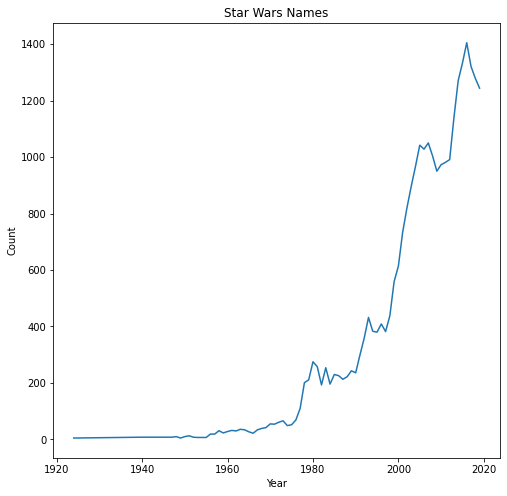

In [6]:
sw_names = ['Luke', 'Leia', 'Han']

## You CAN'T add comments in between continuation sections!!  (it's really all one line)
 #filters dataset for just the rows with star wars names \ # adds up the totals by year
babynames[babynames['Name'].isin(sw_names)] \
         .groupby("Year")["Count"].sum()\
         .plot(ylabel = 'Count', title = 'Star Wars Names', figsize = (8, 8))

# I think they used all states (vice just CA) for their dataset

## Question 1b

Define the fluctuation of a baby name as the mathematical range of its count per year throughout its history (i.e. maximum count subtracted by minimum count). 
$$max(Count_{year}) - min(Count_{year}) $$

Write a line of Pandas code to determine per-state fluctuations for all baby names, sorted from greatest to least.

In [7]:
elections.head(10)


,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878
2,1828,Andrew Jackson,Democratic,642806,win,56.203927
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073
4,1832,Andrew Jackson,Democratic,702735,win,54.574789
5,1832,Henry Clay,National Republican,484205,loss,37.603628
6,1832,William Wirt,Anti-Masonic,100715,loss,7.821583
7,1836,Hugh Lawson White,Whig,146109,loss,10.005985
8,1836,Martin Van Buren,Democratic,763291,win,52.272472
9,1836,William Henry Harrison,Whig,550816,loss,37.721543


In [8]:
max_bn = babynames.groupby(["State","Name"])["Count"].max()
max_bn
#min_bn = babynames.groupby("Name").min() #Note, when pulling the whole df, this finds the min of each column separately
min_bn = babynames.groupby("Name")["Count"].min()
min_bn

#babynames.query("Name == 'Zyon'")

(max_bn - min_bn).sort_values(ascending = False)


State  Name       
CA     Michael        8255
       David          8110
       John           7321
       Robert         7091
       Jessica        6946
                      ... 
       Randeep           0
       Hannahgrace       0
       Hannaley          0
       Hannibal          0
       Emilianna         0
Name: Count, Length: 19830, dtype: int64

In [9]:
#One liner from the solutions!  
babynames.groupby(["State", "Name"])["Count"].agg(lambda s:s.max()-s.min()).sort_values(ascending=False)

State  Name       
CA     Michael        8255
       David          8110
       John           7321
       Robert         7091
       Jessica        6946
                      ... 
       Randeep           0
       Hannahgrace       0
       Hannaley          0
       Hannibal          0
       Emilianna         0
Name: Count, Length: 19830, dtype: int64

## Question 1c

Define an upset as an election result for a party that is an outlier vote share attained in that party's history. Fill in the blanks below to find all the rows in `elections` corresponding to election upsets in American history per this definition.

*Hint:* the `quantile` function can return the quartiles of the data; for example, `elections['\%'].quantile(0.25)` returns the first quartile ($Q_1$). Recall that a point is an outlier if it is outside the interval $[Q_1 - 1.5 \text{IQR}, Q_3 + 1.5 \text{IQR}]$.

In [10]:
def outlier(subdf):
    q1, q3 = subdf.quantile(.25), subdf.quantile(.25)
    iqr = q3-q1
    return subdf[(subdf < (q1-1.5*iqr)) | (subdf > (q3+1.5*iqr))]
elections.groupby("Party")["%"].apply(outlier)

## theier solution passes the whole df but then hardcodes the ["%"], column

# subdf = pd.DataFrame({"a":[5,5,5,5,6,4,1],"b":[1,1,1,-1,1,8,1]})
# outlier(subdf)

Party                    
American              22     21.554001
                      126     0.194862
American Independent  115    13.571218
                      119     1.421524
                      124     0.209640
                               ...    
Whig                  9      37.721543
                      11     53.051213
                      12     49.250523
                      16     47.309296
                      19     44.056548
Name: %, Length: 159, dtype: float64

## Question 1d

Write a line of code to output the following DataFrame showing the average winning and losing vote share for every party that has won an election. 

*Hint:* The arguments to `pivot_table` are `index`,  `columns`, `values`, and `aggfunc`.

In [11]:
pd.pivot_table(
    data=elections,
    index="Party",
    columns="Result",
    values="%",
    aggfunc=np.mean
)

Result,loss,win
Party,,
American,10.874432,NaN
American Independent,5.067461,NaN
Anti-Masonic,7.821583,NaN
Anti-Monopoly,1.335838,NaN
Citizens,0.270182,NaN
Communist,0.261069,NaN
Constitution,0.139860,NaN
Constitutional Union,12.639283,NaN
Democratic,43.697060,51.441864


In [12]:
elections.pivot_table(
    index = "Party",
    columns = "Result",
    values = "%",
    aggfunc=np.mean
).dropna(subset=["win"]) #just drops the rows with an NaN in the win column!

Result,loss,win
Party,,
Democratic,43.697060,51.441864
Democratic-Republican,57.210122,42.789878
National Union,NaN,54.951512
Republican,42.047791,52.366967
Whig,35.258650,50.180255


## Question 1e

Fill in the blanks below to create a new column `Middle Name` containing every candidate's middle name (or middle initial). If a candidate has no middle name, that entry should be NaN. 

*Hint:* The default entry of any element in a DataFrame if unspecified is NaN!


In [27]:
mid = elections["Candidate"].str.split()
mid
elections.loc[mid.str.len() > 2, 'Middle Name'] = mid.str[1] #.str method allows us to apply the string methods to each row!
elections

,Year,Candidate,Party,Popular vote,Result,%,Middle Name
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122,NaN
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,Quincy
2,1828,Andrew Jackson,Democratic,642806,win,56.203927,NaN
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073,Quincy
4,1832,Andrew Jackson,Democratic,702735,win,54.574789,NaN
...,...,...,...,...,...,...,...
173,2016,Donald Trump,Republican,62984828,win,46.407862,NaN
174,2016,Evan McMullin,Independent,732273,loss,0.539546,NaN
175,2016,Gary Johnson,Libertarian,4489235,loss,3.307714,NaN
176,2016,Hillary Clinton,Democratic,65853514,loss,48.521539,NaN


In [39]:
# check how we did -- this method ain't great..."George H. W. Bush", for example
elections[~elections["Middle Name"].isnull()]

#or

elections[elections["Middle Name"].notnull()]

#or

#elections[pd.isnull(elections["Middle Name"])]

elections[pd.notnull(elections["Middle Name"])]

,Year,Candidate,Party,Popular vote,Result,%,Middle Name
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,Quincy
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073,Quincy
7,1836,Hugh Lawson White,Whig,146109,loss,10.005985,Lawson
8,1836,Martin Van Buren,Democratic,763291,win,52.272472,Van
9,1836,William Henry Harrison,Whig,550816,loss,37.721543,Henry
10,1840,Martin Van Buren,Democratic,1128854,loss,46.948787,Van
11,1840,William Henry Harrison,Whig,1275583,win,53.051213,Henry
15,1848,Martin Van Buren,Free Soil,291501,loss,10.138474,Van
18,1852,John P. Hale,Free Soil,155210,loss,4.930283,P.
21,1856,John C. Frémont,Republican,1342345,loss,33.139919,C.


## Question 1f

Define election twins as two candidates that share the same middle name (or middle initial). Fill in the code below to determine the number of election twins.

*Hint:* Try to use a merge, and recall that for merges with non-unique column names, Pandas will rename the non-unique column name with an `_x` suffix for the left table and `_y` suffix for the right table (i.e. for a column `col`, the resulting names would be `col_x` and `col_y`).

In [56]:
#ended up skipping -- not sure what they are going for here

bill = elections.groupby(["Year","Middle Name"]).count()
bill

middle_yes = elections[elections["Middle Name"].notnull()]
middle_yes.head()

Candidate  Party  Popular vote  Result  %
Year Middle Name                                           
1824 Quincy               1      1             1       1  1
1828 Quincy               1      1             1       1  1
1836 Henry                1      1             1       1  1
     Lawson               1      1             1       1  1
     Van                  1      1             1       1  1
1840 Henry                1      1             1       1  1
     Van                  1      1             1       1  1
1848 Van                  1      1             1       1  1
1852 P.                   1      1             1       1  1
1856 C.                   1      1             1       1  1
1860 A.                   1      1             1       1  1
     C.                   1      1             1       1  1
1864 B.                   1      1             1       1  1
1876 J.                   1      1             1       1  1
1880 B.                   1      1             1       1  1
     Scott                1      1             1       1  1
1884 G.                   1      1             1       1  1
     St.                  1      1             1       1  1
1888 B.                   1      1             1       1  1
1892 B.                   1      1             1       1  1
1896 Jennings             1      1             1       1  1
     M.                   1      1             1       1  1
1900 G.                   1      1             1       1  1
     Jennings             1      1             1       1  1
1904 B.                   1      1             1       1  1
     C.                   1      1             1       1  1
     E.                   1      1             1       1  1
     V.                   1      1             1       1  1
1908 Jennings             1      1             1       1  1
     V.                   1      1             1       1  1
     W.                   1      1             1       1  1
1912 V.                   1      1             1       1  1
     W.                   1      1             1       1  1
1916 Evans                1      1             1       1  1
     L.                   1      1             1       1  1
1920 M.                   1      1             1       1  1
     P.                   1      1             1       1  1
     S.                   1      1             1       1  1
     V.                   1      1             1       1  1
1924 La                   1      1             1       1  1
     W.                   1      1             1       1  1
1932 Z.                   1      1             1       1  1
1944 E.                   1      1             1       1  1
1948 A.                   2      2             2       2  2
     E.                   1      1             1       1  1
1956 Coleman              1      1             1       1  1
1972 G.                   1      1             1       1  1
1976 J.                   1      1             1       1  1
1980 B.                   1      1             1       1  1
1988 H.                   1      1             1       1  1
1992 H.                   1      1             1       1  1
2000 W.                   1      1             1       1  1
2004 W.                   1      1             1       1  1

In [53]:
middle_yes.merge(middle_yes, on="Middle Name")

,Year_x,Candidate_x,Party_x,Popular vote_x,Result_x,%_x,Middle Name,Year_y,Candidate_y,Party_y,Popular vote_y,Result_y,%_y
0,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,Quincy,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,Quincy,1828,John Quincy Adams,National Republican,500897,loss,43.796073
2,1828,John Quincy Adams,National Republican,500897,loss,43.796073,Quincy,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073,Quincy,1828,John Quincy Adams,National Republican,500897,loss,43.796073
4,1836,Hugh Lawson White,Whig,146109,loss,10.005985,Lawson,1836,Hugh Lawson White,Whig,146109,loss,10.005985
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,1956,T. Coleman Andrews,States' Rights,107929,loss,0.174883,Coleman,1956,T. Coleman Andrews,States' Rights,107929,loss,0.174883
160,1988,George H. W. Bush,Republican,48886597,win,53.518845,H.,1988,George H. W. Bush,Republican,48886597,win,53.518845
161,1988,George H. W. Bush,Republican,48886597,win,53.518845,H.,1992,George H. W. Bush,Republican,39104550,loss,37.544784
162,1992,George H. W. Bush,Republican,39104550,loss,37.544784,H.,1988,George H. W. Bush,Republican,48886597,win,53.518845


In [52]:
pd.merge(left=middle_yes, right=middle_yes, on="Middle Name")

,Year_x,Candidate_x,Party_x,Popular vote_x,Result_x,%_x,Middle Name,Year_y,Candidate_y,Party_y,Popular vote_y,Result_y,%_y
0,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,Quincy,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,Quincy,1828,John Quincy Adams,National Republican,500897,loss,43.796073
2,1828,John Quincy Adams,National Republican,500897,loss,43.796073,Quincy,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073,Quincy,1828,John Quincy Adams,National Republican,500897,loss,43.796073
4,1836,Hugh Lawson White,Whig,146109,loss,10.005985,Lawson,1836,Hugh Lawson White,Whig,146109,loss,10.005985
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,1956,T. Coleman Andrews,States' Rights,107929,loss,0.174883,Coleman,1956,T. Coleman Andrews,States' Rights,107929,loss,0.174883
160,1988,George H. W. Bush,Republican,48886597,win,53.518845,H.,1988,George H. W. Bush,Republican,48886597,win,53.518845
161,1988,George H. W. Bush,Republican,48886597,win,53.518845,H.,1992,George H. W. Bush,Republican,39104550,loss,37.544784
162,1992,George H. W. Bush,Republican,39104550,loss,37.544784,H.,1988,George H. W. Bush,Republican,48886597,win,53.518845


In [54]:
def election_twins(elections):
    elections = elections[elections["Middle Name"].notnull()]
    twins = elections.merge(middle_yes, on="Middle Name") #this creates lots of dups, see example
    twins = twins[twins["Candidate_x"] < twins["Candidate_y"]]  #uses lexigraphical ordering to remove duplicate matches and when
    return len(twins)

election_twins(elections)

36

### Simpler example of this problem and merging a table onto itself

In [63]:
df = pd.DataFrame({"first":["bill", "bob", "fred", "ed"], "middle":["matt", "mark", "luke", "john"]})
df

,first,middle
0,bill,matt
1,bob,mark
2,fred,luke
3,ed,john


In [64]:
# for a dataframe with no matching middle names, it just duplicates the first and "matches" each person to himself
df.merge(df, on="middle")

,first_x,middle,first_y
0,bill,matt,bill
1,bob,mark,bob
2,fred,luke,fred
3,ed,john,ed


if we change "bob mark" to "bob matt", we get 3 more matt rows (but lose the mark row)

1. bill to bill (original)
2. bill to bob (row 1 to row 2)
3. bob to bill (row 2 to row 1 -- the reverse)
4. bob to bob (replaces the bob to bob mark row)

In [70]:
# if we change "bob mark" to "bob matt", we get 3 more matt rows (but lose the mark row)
# bill to bill
df.loc[1,"middle"] = "matt"
df1 = df.merge(df, on="middle")
df1

,first_x,middle,first_y
0,bill,matt,bill
1,bill,matt,bob
2,bob,matt,bill
3,bob,matt,bob
4,fred,luke,fred
5,ed,john,ed


To filter these, use lexiographical order

In [72]:
# eliminates the rows that aren't the same
df1[df1["first_x"] == df1["first_y"]] #


,first_x,middle,first_y
0,bill,matt,bill
3,bob,matt,bob
4,fred,luke,fred
5,ed,john,ed


In [73]:
# removes the self matches
df1[df1["first_x"] != df1['first_y']]

,first_x,middle,first_y
1,bill,matt,bob
2,bob,matt,bill


In [74]:
# removes the self-matches and one of the duplicates
df1[df1["first_x"] < df1['first_y']]

,first_x,middle,first_y
1,bill,matt,bob


In [75]:
# can use either > or <
df1[df1["first_x"] > df1['first_y']]

,first_x,middle,first_y
2,bob,matt,bill
